In [170]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import statsmodels.api as sm
import hockey_scraper
import pickle
import time
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
pd.set_option('display.max_columns', None)

In [53]:
df = pd.read_csv('data/all_games_multirolling_SVA.csv')

In [54]:
df = df.dropna()

In [55]:
df.shape

(4537, 123)

In [63]:
htw = pd.DataFrame(df['Home_Team_Won'].value_counts(normalize = True)).reset_index()
htw['Home_Team_Won'] = htw['Home_Team_Won']*100
htw.iloc[0,0] = 'Home'
htw.iloc[1,0] = 'Away'
htw.rename(columns = {'index' : 'Home Or Away'}, inplace = True)

htw

,Home Or Away,Home_Team_Won
0,Home,54.044523
1,Away,45.955477


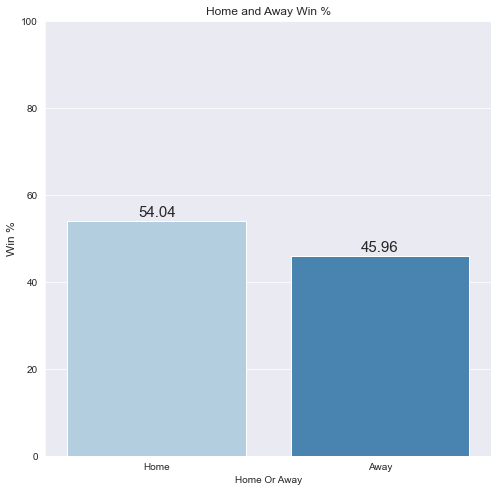

In [171]:
fig, ax = plt.subplots(figsize = (8,8))

ax = sns.barplot(x = htw['Home Or Away'], y = htw['Home_Team_Won'], orient = 'v', palette = 'Blues')
ax.set_title('Home and Away Win %', fontsize = 12)
ax.set_ylabel('Win %', fontsize =12)
ax.set_ylim(0,100)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
plt.show()

In [65]:
df.head()

,Unnamed: 0,game_id,date,venue,home_team,away_team,start_time,home_score,away_score,status,Home_Team_Won,Home_Team_Key,Away_Team_Key,home_goalie,home_Goalie_FenwickSV%,home_Goalie_GSAx/60,home_Goalie_HDCSV%,away_goalie,away_Goalie_FenwickSV%,away_Goalie_GSAx/60,away_Goalie_HDCSV%,home_Team_Key,home_Game_Number,home_last_3_FF%_5v5,home_last_3_GF%_5v5,home_last_3_xGF%_5v5,home_last_3_SH%,home_last3_pp_TOI_per_game,home_last3_xGF_per_min_pp,home_last3_pk_TOI_per_game,home_last3_xGA_per_min_pk,home_B2B,home_last_5_FF%_5v5,home_last_5_GF%_5v5,home_last_5_xGF%_5v5,home_last_5_SH%,home_last5_pp_TOI_per_game,home_last5_xGF_per_min_pp,home_last5_pk_TOI_per_game,home_last5_xGA_per_min_pk,home_last_10_FF%_5v5,home_last_10_GF%_5v5,home_last_10_xGF%_5v5,home_last_10_SH%,home_last10_pp_TOI_per_game,home_last10_xGF_per_min_pp,home_last10_pk_TOI_per_game,home_last10_xGA_per_min_pk,home_last_20_FF%_5v5,home_last_20_GF%_5v5,home_last_20_xGF%_5v5,home_last_20_SH%,home_last20_pp_TOI_per_game,home_last20_xGF_per_min_pp,home_last20_pk_TOI_per_game,home_last20_xGA_per_min_pk,home_last_30_FF%_5v5,home_last_30_GF%_5v5,home_last_30_xGF%_5v5,home_last_30_SH%,home_last30_pp_TOI_per_game,home_last30_xGF_per_min_pp,home_last30_pk_TOI_per_game,home_last30_xGA_per_min_pk,home_last_40_FF%_5v5,home_last_40_GF%_5v5,home_last_40_xGF%_5v5,home_last_40_SH%,home_last40_pp_TOI_per_game,home_last40_xGF_per_min_pp,home_last40_pk_TOI_per_game,home_last40_xGA_per_min_pk,away_Team_Key,away_Game_Number,away_last_3_FF%_5v5,away_last_3_GF%_5v5,away_last_3_xGF%_5v5,away_last_3_SH%,away_last3_pp_TOI_per_game,away_last3_xGF_per_min_pp,away_last3_pk_TOI_per_game,away_last3_xGA_per_min_pk,away_B2B,away_last_5_FF%_5v5,away_last_5_GF%_5v5,away_last_5_xGF%_5v5,away_last_5_SH%,away_last5_pp_TOI_per_game,away_last5_xGF_per_min_pp,away_last5_pk_TOI_per_game,away_last5_xGA_per_min_pk,away_last_10_FF%_5v5,away_last_10_GF%_5v5,away_last_10_xGF%_5v5,away_last_10_SH%,away_last10_pp_TOI_per_game,away_last10_xGF_per_min_pp,away_last10_pk_TOI_per_game,away_last10_xGA_per_min_pk,away_last_20_FF%_5v5,away_last_20_GF%_5v5,away_last_20_xGF%_5v5,away_last_20_SH%,away_last20_pp_TOI_per_game,away_last20_xGF_per_min_pp,away_last20_pk_TOI_per_game,away_last20_xGA_per_min_pk,away_last_30_FF%_5v5,away_last_30_GF%_5v5,away_last_30_xGF%_5v5,away_last_30_SH%,away_last30_pp_TOI_per_game,away_last30_xGF_per_min_pp,away_last30_pk_TOI_per_game,away_last30_xGA_per_min_pk,away_last_40_FF%_5v5,away_last_40_GF%_5v5,away_last_40_xGF%_5v5,away_last_40_SH%,away_last40_pp_TOI_per_game,away_last40_xGF_per_min_pp,away_last40_pk_TOI_per_game,away_last40_xGA_per_min_pk
0,0,2017020001,2017-10-04,Bell MTS Place,WPG,TOR,2017-10-04 23:00:00,2,7,Final,0,WPG_2017-10-04,TOR_2017-10-04,Steve Mason,0.932657,-0.334940,0.866667,Frederik Andersen,0.942629,0.027934,0.872792,WPG_2017-10-04,1.0,52.073795,62.416999,48.839009,10.258649,3.444444,0.063871,4.005556,0.090707,0.0,52.399869,57.080799,51.663405,9.426112,4.190000,0.079714,3.693333,0.098556,50.977189,50.738779,51.924105,7.380972,5.128333,0.091453,4.315000,0.128158,49.296838,51.281437,51.260619,8.999958,5.860833,0.102801,5.440000,0.105423,49.171944,50.109126,49.007605,8.809652,5.171111,0.119961,4.815000,0.115057,48.803377,50.127801,48.992719,9.025236,5.328333,0.112699,4.923333,0.104858,TOR_2017-10-04,1.0,51.594385,47.355164,48.770492,8.692972,6.450000,0.106460,3.394444,0.111948,0.0,52.562502,45.937500,48.770492,6.967375,5.893333,0.069910,3.070000,0.074267,50.792085,48.572198,49.886878,7.837427,5.073333,0.080420,4.235000,0.114522,49.687136,49.188289,49.131362,7.552033,4.525833,0.118431,4.195000,0.123361,50.085902,51.013795,50.000000,7.493438,4.538889,0.128519,4.363889,0.133978,49.991679,51.399425,49.339386,8.124451,4.646667,0.122400,4.540000,0.133976
1,1,2017020002,2017-10-04,PPG Paints Arena,PIT,STL,2017-10-05 00:00:00,4,5,Final,0,PIT_2017-10-04,STL_2017-10-04,Matt Murray,0.941176,0.205712,0.869942,Jake Allen,0.945897,-0.138771,0.882353,PIT_2017-10-04,1.0,44.169509,52.837327,49.560

In [68]:
conditions = [((df['date'] >= '2017-10-04') & (df['date'] <= '2018-04-08')),
              ((df['date'] >= '2018-10-03') & (df['date'] <= '2019-04-06')),
              ((df['date'] >= '2019-10-02') & (df['date'] <= '2020-03-12')),
              ((df['date'] >= '2021-01-13') & (df['date'] <= '2021-04-29'))
             ]
, 
choices = ['2017-2018',
           '2018-2019',
           '2019-2020',
           '2020-2021']
           
    

df['Season'] = np.select(conditions, choices)

In [71]:
htw_season = pd.DataFrame(df.groupby('Season')['Home_Team_Won'].value_counts(normalize = 'True'))

In [86]:
htw_s = htw_season.unstack()['Home_Team_Won']

In [93]:
htw_s = htw_s.rename(columns = {0: 'Away', 1: 'Home'})
htw_s 

Home_Team_Won,Away,Home
Season,,
2017-2018,0.439787,0.560213
2018-2019,0.463285,0.536715
2019-2020,0.469114,0.530886
2020-2021,0.472681,0.527319


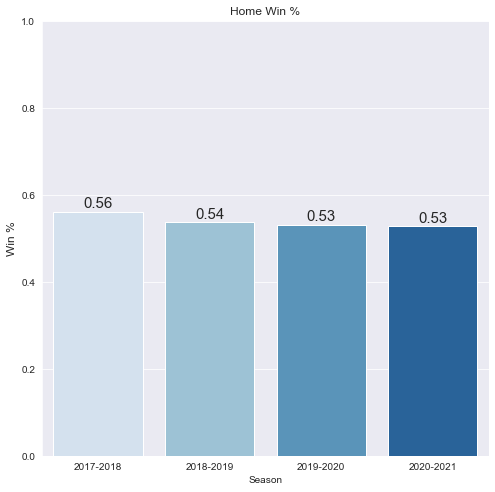

In [172]:
fig, ax = plt.subplots(figsize = (8,8))

ax = sns.barplot(x = 'Season', y = 'Home_Team_Won', data = df, palette = 'Blues', ci=None)

ax.set_title('Home Win %', fontsize = 12)
ax.set_ylabel('Win %', fontsize =12)
ax.set_ylim(0,1)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
plt.show()

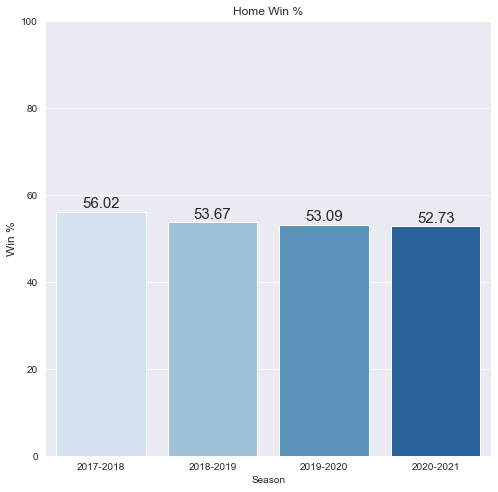

In [173]:
fig, ax = plt.subplots(figsize = (8,8))

ax = sns.barplot(x = df['Season'], y = df['Home_Team_Won'].apply(lambda x: x*100), palette = 'Blues', ci=None)

ax.set_title('Home Win %', fontsize = 12)
ax.set_ylabel('Win %', fontsize =12)
ax.set_ylim(0,100)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
plt.show()

In [113]:
df.head()

,Unnamed: 0,game_id,date,venue,home_team,away_team,start_time,home_score,away_score,status,Home_Team_Won,Home_Team_Key,Away_Team_Key,home_goalie,home_Goalie_FenwickSV%,home_Goalie_GSAx/60,home_Goalie_HDCSV%,away_goalie,away_Goalie_FenwickSV%,away_Goalie_GSAx/60,away_Goalie_HDCSV%,home_Team_Key,home_Game_Number,home_last_3_FF%_5v5,home_last_3_GF%_5v5,home_last_3_xGF%_5v5,home_last_3_SH%,home_last3_pp_TOI_per_game,home_last3_xGF_per_min_pp,home_last3_pk_TOI_per_game,home_last3_xGA_per_min_pk,home_B2B,home_last_5_FF%_5v5,home_last_5_GF%_5v5,home_last_5_xGF%_5v5,home_last_5_SH%,home_last5_pp_TOI_per_game,home_last5_xGF_per_min_pp,home_last5_pk_TOI_per_game,home_last5_xGA_per_min_pk,home_last_10_FF%_5v5,home_last_10_GF%_5v5,home_last_10_xGF%_5v5,home_last_10_SH%,home_last10_pp_TOI_per_game,home_last10_xGF_per_min_pp,home_last10_pk_TOI_per_game,home_last10_xGA_per_min_pk,home_last_20_FF%_5v5,home_last_20_GF%_5v5,home_last_20_xGF%_5v5,home_last_20_SH%,home_last20_pp_TOI_per_game,home_last20_xGF_per_min_pp,home_last20_pk_TOI_per_game,home_last20_xGA_per_min_pk,home_last_30_FF%_5v5,home_last_30_GF%_5v5,home_last_30_xGF%_5v5,home_last_30_SH%,home_last30_pp_TOI_per_game,home_last30_xGF_per_min_pp,home_last30_pk_TOI_per_game,home_last30_xGA_per_min_pk,home_last_40_FF%_5v5,home_last_40_GF%_5v5,home_last_40_xGF%_5v5,home_last_40_SH%,home_last40_pp_TOI_per_game,home_last40_xGF_per_min_pp,home_last40_pk_TOI_per_game,home_last40_xGA_per_min_pk,away_Team_Key,away_Game_Number,away_last_3_FF%_5v5,away_last_3_GF%_5v5,away_last_3_xGF%_5v5,away_last_3_SH%,away_last3_pp_TOI_per_game,away_last3_xGF_per_min_pp,away_last3_pk_TOI_per_game,away_last3_xGA_per_min_pk,away_B2B,away_last_5_FF%_5v5,away_last_5_GF%_5v5,away_last_5_xGF%_5v5,away_last_5_SH%,away_last5_pp_TOI_per_game,away_last5_xGF_per_min_pp,away_last5_pk_TOI_per_game,away_last5_xGA_per_min_pk,away_last_10_FF%_5v5,away_last_10_GF%_5v5,away_last_10_xGF%_5v5,away_last_10_SH%,away_last10_pp_TOI_per_game,away_last10_xGF_per_min_pp,away_last10_pk_TOI_per_game,away_last10_xGA_per_min_pk,away_last_20_FF%_5v5,away_last_20_GF%_5v5,away_last_20_xGF%_5v5,away_last_20_SH%,away_last20_pp_TOI_per_game,away_last20_xGF_per_min_pp,away_last20_pk_TOI_per_game,away_last20_xGA_per_min_pk,away_last_30_FF%_5v5,away_last_30_GF%_5v5,away_last_30_xGF%_5v5,away_last_30_SH%,away_last30_pp_TOI_per_game,away_last30_xGF_per_min_pp,away_last30_pk_TOI_per_game,away_last30_xGA_per_min_pk,away_last_40_FF%_5v5,away_last_40_GF%_5v5,away_last_40_xGF%_5v5,away_last_40_SH%,away_last40_pp_TOI_per_game,away_last40_xGF_per_min_pp,away_last40_pk_TOI_per_game,away_last40_xGA_per_min_pk,Season
0,0,2017020001,2017-10-04,Bell MTS Place,WPG,TOR,2017-10-04 23:00:00,2,7,Final,0,WPG_2017-10-04,TOR_2017-10-04,Steve Mason,0.932657,-0.334940,0.866667,Frederik Andersen,0.942629,0.027934,0.872792,WPG_2017-10-04,1.0,52.073795,62.416999,48.839009,10.258649,3.444444,0.063871,4.005556,0.090707,0.0,52.399869,57.080799,51.663405,9.426112,4.190000,0.079714,3.693333,0.098556,50.977189,50.738779,51.924105,7.380972,5.128333,0.091453,4.315000,0.128158,49.296838,51.281437,51.260619,8.999958,5.860833,0.102801,5.440000,0.105423,49.171944,50.109126,49.007605,8.809652,5.171111,0.119961,4.815000,0.115057,48.803377,50.127801,48.992719,9.025236,5.328333,0.112699,4.923333,0.104858,TOR_2017-10-04,1.0,51.594385,47.355164,48.770492,8.692972,6.450000,0.106460,3.394444,0.111948,0.0,52.562502,45.937500,48.770492,6.967375,5.893333,0.069910,3.070000,0.074267,50.792085,48.572198,49.886878,7.837427,5.073333,0.080420,4.235000,0.114522,49.687136,49.188289,49.131362,7.552033,4.525833,0.118431,4.195000,0.123361,50.085902,51.013795,50.000000,7.493438,4.538889,0.128519,4.363889,0.133978,49.991679,51.399425,49.339386,8.124451,4.646667,0.122400,4.540000,0.133976,2017-2018
1,1,2017020002,2017-10-04,PPG Paints Arena,PIT,STL,2017-10-05 00:00:00,4,5,Final,0,PIT_2017-10-04,STL_2017-10-04,Matt Murray,0.941176,0.205712,0.869942,Jake Allen,0.945897,-0.138771,0.882353,PIT_2017-10-04,1.0,44.169509

In [131]:
hb2b = pd.DataFrame(df[(df['home_B2B'] == 1) & (df['away_B2B'] == 0)]['Home_Team_Won'].value_counts(normalize = True))
hb2b['B2B'] = 'Home'
hb2b

,Home_Team_Won,B2B
0,0.546341,Home
1,0.453659,Home


In [134]:
ab2b = pd.DataFrame(df[(df['home_B2B'] == 0) & (df['away_B2B'] == 1)]['Home_Team_Won'].value_counts(normalize = True))
ab2b['B2B'] = 'Away'
ab2b

,Home_Team_Won,B2B
1,0.577348,Away
0,0.422652,Away


In [141]:
gb2b = pd.DataFrame(df['Home_Team_Won'].value_counts(normalize = True))
gb2b['B2B'] = 'General'
gb2b

,Home_Team_Won,B2B
1,0.540445,General
0,0.459555,General


In [136]:
bb2b = pd.DataFrame(df[(df['home_B2B'] == 1) & (df['away_B2B'] == 1)]['Home_Team_Won'].value_counts(normalize = True))
bb2b['B2B'] = 'Both'
bb2b

,Home_Team_Won,B2B
1,0.509025,Both
0,0.490975,Both


In [139]:
df[(df['home_B2B'] == 1) & (df['away_B2B'] == 1)].shape

(277, 124)

In [277]:
b2b = pd.concat([nb2b, hb2b, ab2b, bb2b])

In [278]:
b2b.loc[1]

,Home_Team_Won,B2B
1,0.540445,Neither
1,0.453659,Home
1,0.577348,Away
1,0.509025,Both


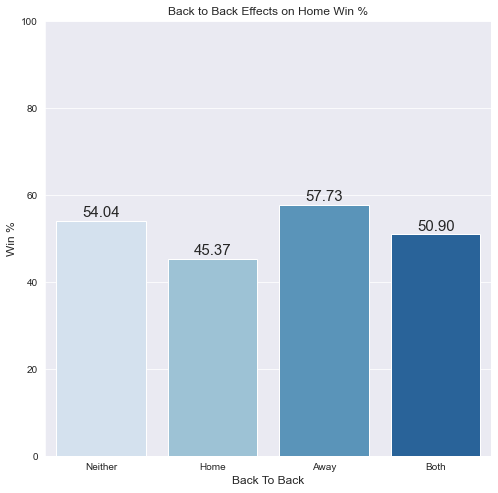

In [279]:
fig, ax = plt.subplots(figsize = (8,8))

ax = sns.barplot(x = b2b.loc[1, 'B2B'], y = b2b.loc[1, 'Home_Team_Won'].apply(lambda x: x *100), orient = 'v', palette = 'Blues')
ax.set_title('Back to Back Effects on Home Win %', fontsize = 12)
ax.set_ylabel('Win %', fontsize =12)
ax.set_xlabel('Back To Back', fontsize =12)
ax.set_ylim(0,100)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
plt.show()

In [160]:
df.head()

,Unnamed: 0,game_id,date,venue,home_team,away_team,start_time,home_score,away_score,status,Home_Team_Won,Home_Team_Key,Away_Team_Key,home_goalie,home_Goalie_FenwickSV%,home_Goalie_GSAx/60,home_Goalie_HDCSV%,away_goalie,away_Goalie_FenwickSV%,away_Goalie_GSAx/60,away_Goalie_HDCSV%,home_Team_Key,home_Game_Number,home_last_3_FF%_5v5,home_last_3_GF%_5v5,home_last_3_xGF%_5v5,home_last_3_SH%,home_last3_pp_TOI_per_game,home_last3_xGF_per_min_pp,home_last3_pk_TOI_per_game,home_last3_xGA_per_min_pk,home_B2B,home_last_5_FF%_5v5,home_last_5_GF%_5v5,home_last_5_xGF%_5v5,home_last_5_SH%,home_last5_pp_TOI_per_game,home_last5_xGF_per_min_pp,home_last5_pk_TOI_per_game,home_last5_xGA_per_min_pk,home_last_10_FF%_5v5,home_last_10_GF%_5v5,home_last_10_xGF%_5v5,home_last_10_SH%,home_last10_pp_TOI_per_game,home_last10_xGF_per_min_pp,home_last10_pk_TOI_per_game,home_last10_xGA_per_min_pk,home_last_20_FF%_5v5,home_last_20_GF%_5v5,home_last_20_xGF%_5v5,home_last_20_SH%,home_last20_pp_TOI_per_game,home_last20_xGF_per_min_pp,home_last20_pk_TOI_per_game,home_last20_xGA_per_min_pk,home_last_30_FF%_5v5,home_last_30_GF%_5v5,home_last_30_xGF%_5v5,home_last_30_SH%,home_last30_pp_TOI_per_game,home_last30_xGF_per_min_pp,home_last30_pk_TOI_per_game,home_last30_xGA_per_min_pk,home_last_40_FF%_5v5,home_last_40_GF%_5v5,home_last_40_xGF%_5v5,home_last_40_SH%,home_last40_pp_TOI_per_game,home_last40_xGF_per_min_pp,home_last40_pk_TOI_per_game,home_last40_xGA_per_min_pk,away_Team_Key,away_Game_Number,away_last_3_FF%_5v5,away_last_3_GF%_5v5,away_last_3_xGF%_5v5,away_last_3_SH%,away_last3_pp_TOI_per_game,away_last3_xGF_per_min_pp,away_last3_pk_TOI_per_game,away_last3_xGA_per_min_pk,away_B2B,away_last_5_FF%_5v5,away_last_5_GF%_5v5,away_last_5_xGF%_5v5,away_last_5_SH%,away_last5_pp_TOI_per_game,away_last5_xGF_per_min_pp,away_last5_pk_TOI_per_game,away_last5_xGA_per_min_pk,away_last_10_FF%_5v5,away_last_10_GF%_5v5,away_last_10_xGF%_5v5,away_last_10_SH%,away_last10_pp_TOI_per_game,away_last10_xGF_per_min_pp,away_last10_pk_TOI_per_game,away_last10_xGA_per_min_pk,away_last_20_FF%_5v5,away_last_20_GF%_5v5,away_last_20_xGF%_5v5,away_last_20_SH%,away_last20_pp_TOI_per_game,away_last20_xGF_per_min_pp,away_last20_pk_TOI_per_game,away_last20_xGA_per_min_pk,away_last_30_FF%_5v5,away_last_30_GF%_5v5,away_last_30_xGF%_5v5,away_last_30_SH%,away_last30_pp_TOI_per_game,away_last30_xGF_per_min_pp,away_last30_pk_TOI_per_game,away_last30_xGA_per_min_pk,away_last_40_FF%_5v5,away_last_40_GF%_5v5,away_last_40_xGF%_5v5,away_last_40_SH%,away_last40_pp_TOI_per_game,away_last40_xGF_per_min_pp,away_last40_pk_TOI_per_game,away_last40_xGA_per_min_pk,Season
0,0,2017020001,2017-10-04,Bell MTS Place,WPG,TOR,2017-10-04 23:00:00,2,7,Final,0,WPG_2017-10-04,TOR_2017-10-04,Steve Mason,0.932657,-0.334940,0.866667,Frederik Andersen,0.942629,0.027934,0.872792,WPG_2017-10-04,1.0,52.073795,62.416999,48.839009,10.258649,3.444444,0.063871,4.005556,0.090707,0.0,52.399869,57.080799,51.663405,9.426112,4.190000,0.079714,3.693333,0.098556,50.977189,50.738779,51.924105,7.380972,5.128333,0.091453,4.315000,0.128158,49.296838,51.281437,51.260619,8.999958,5.860833,0.102801,5.440000,0.105423,49.171944,50.109126,49.007605,8.809652,5.171111,0.119961,4.815000,0.115057,48.803377,50.127801,48.992719,9.025236,5.328333,0.112699,4.923333,0.104858,TOR_2017-10-04,1.0,51.594385,47.355164,48.770492,8.692972,6.450000,0.106460,3.394444,0.111948,0.0,52.562502,45.937500,48.770492,6.967375,5.893333,0.069910,3.070000,0.074267,50.792085,48.572198,49.886878,7.837427,5.073333,0.080420,4.235000,0.114522,49.687136,49.188289,49.131362,7.552033,4.525833,0.118431,4.195000,0.123361,50.085902,51.013795,50.000000,7.493438,4.538889,0.128519,4.363889,0.133978,49.991679,51.399425,49.339386,8.124451,4.646667,0.122400,4.540000,0.133976,2017-2018
1,1,2017020002,2017-10-04,PPG Paints Arena,PIT,STL,2017-10-05 00:00:00,4,5,Final,0,PIT_2017-10-04,STL_2017-10-04,Matt Murray,0.941176,0.205712,0.869942,Jake Allen,0.945897,-0.138771,0.882353,PIT_2017-10-04,1.0,44.169509

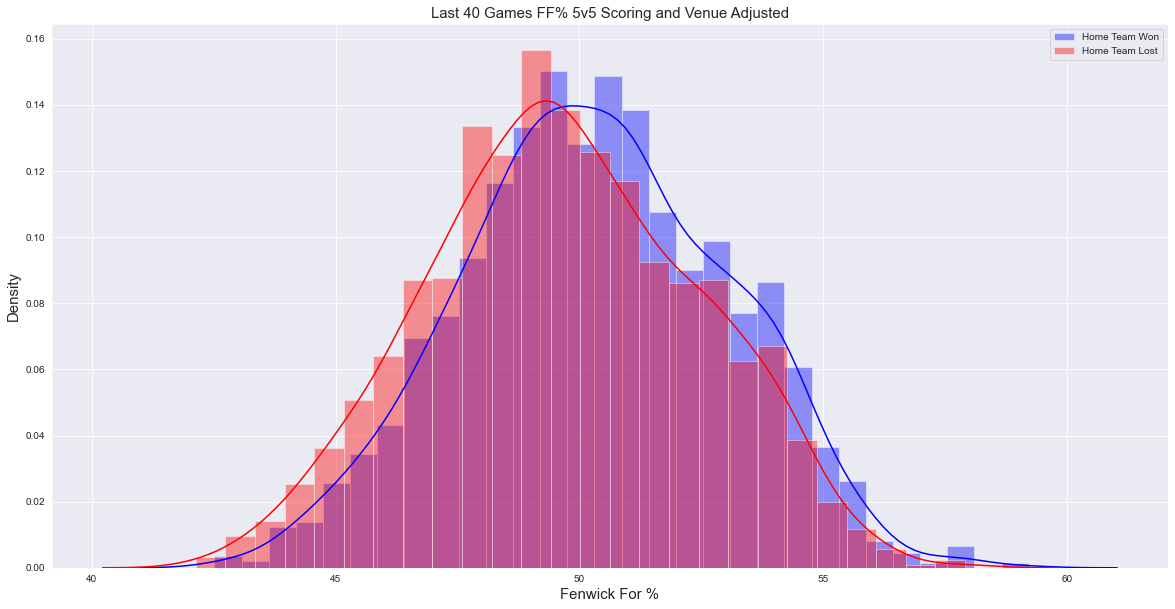

In [175]:
fig,ax = plt.subplots(figsize = (20,10))

ax = sns.distplot(df[df['Home_Team_Won']==1]['home_last_40_FF%_5v5'], color = 'blue', label = 'Home Team Won')
ax = sns.distplot(df[df['Home_Team_Won']==0]['home_last_40_FF%_5v5'], color = 'red', label = 'Home Team Lost')
# ax = sns.distplot(df[df['Bankrupt?']==1]['ROA(A) before interest and % after tax'].apply(lambda x: x*100), color = 'red', label = 'Bankrupt')
ax.set_title('Last 40 Games FF% 5v5 Scoring and Venue Adjusted', fontsize = 15)
ax.set_xlabel('Fenwick For %', fontsize = 15)
ax.set_ylabel('Density', fontsize = 15)
ax.legend(loc = 'upper right')
# ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.show()

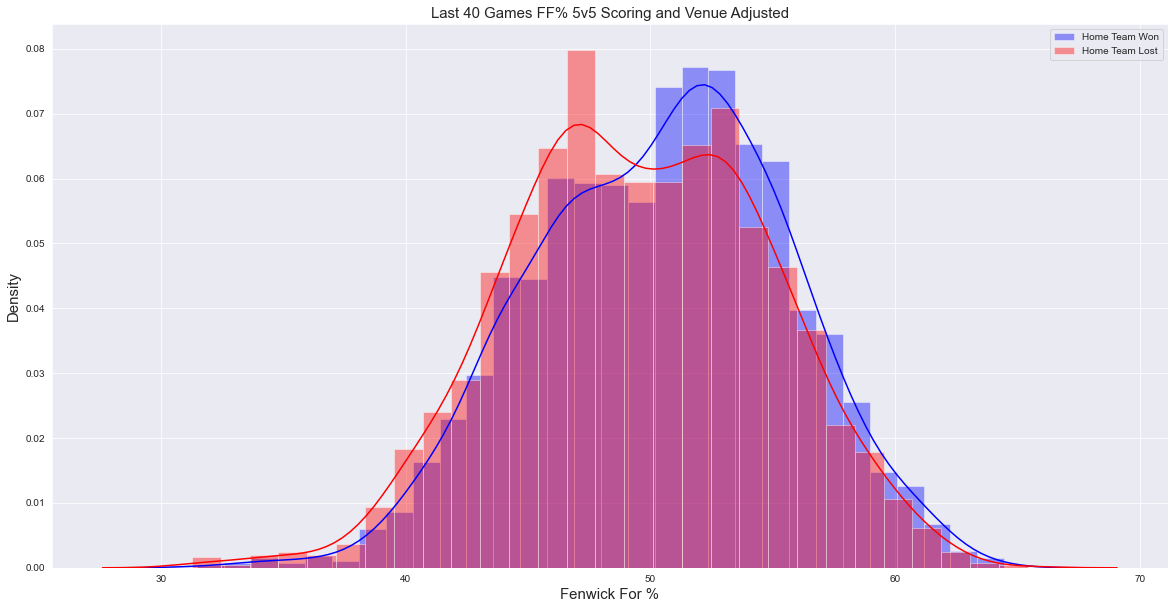

In [181]:
fig,ax = plt.subplots(figsize = (20,10))

ax = sns.distplot(df[df['Home_Team_Won']==1]['home_last_40_GF%_5v5'], color = 'blue', label = 'Home Team Won')
ax = sns.distplot(df[df['Home_Team_Won']==0]['home_last_40_GF%_5v5'], color = 'red', label = 'Home Team Lost')
# ax = sns.distplot(df[df['Bankrupt?']==1]['ROA(A) before interest and % after tax'].apply(lambda x: x*100), color = 'red', label = 'Bankrupt')
ax.set_title('Last 40 Games FF% 5v5 Scoring and Venue Adjusted', fontsize = 15)
ax.set_xlabel('Fenwick For %', fontsize = 15)
ax.set_ylabel('Density', fontsize = 15)
ax.legend(loc = 'upper right')
# ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.show()

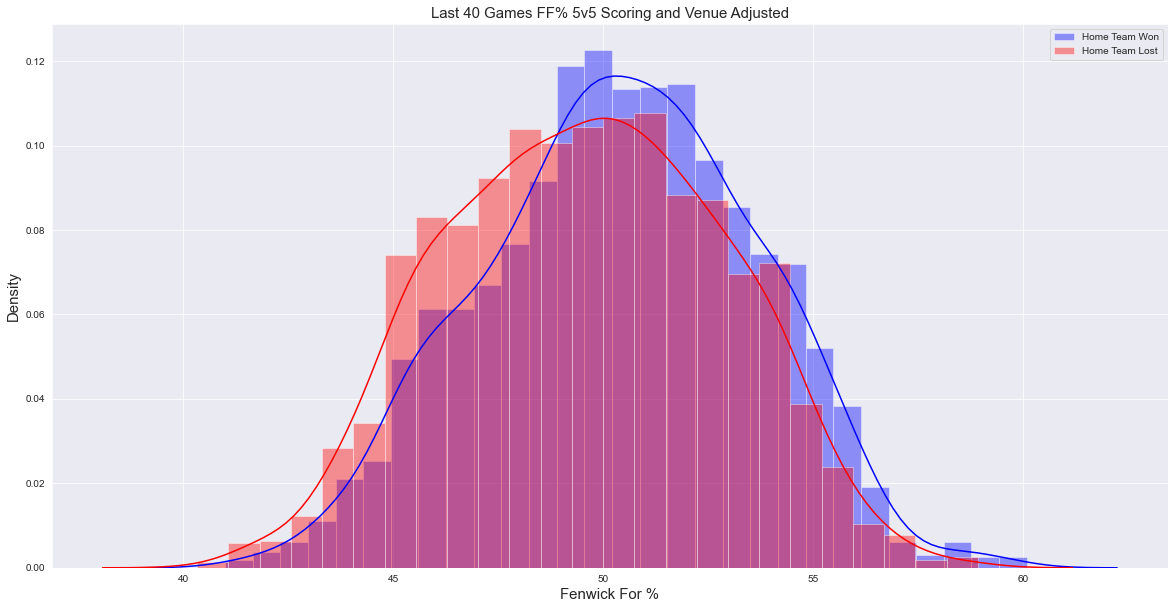

In [183]:
fig,ax = plt.subplots(figsize = (20,10))

ax = sns.distplot(df[df['Home_Team_Won']==1]['home_last_40_xGF%_5v5'], color = 'blue', label = 'Home Team Won')
ax = sns.distplot(df[df['Home_Team_Won']==0]['home_last_40_xGF%_5v5'], color = 'red', label = 'Home Team Lost')
# ax = sns.distplot(df[df['Bankrupt?']==1]['ROA(A) before interest and % after tax'].apply(lambda x: x*100), color = 'red', label = 'Bankrupt')
ax.set_title('Last 40 Games FF% 5v5 Scoring and Venue Adjusted', fontsize = 15)
ax.set_xlabel('Fenwick For %', fontsize = 15)
ax.set_ylabel('Density', fontsize = 15)
ax.legend(loc = 'upper right')
# ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.show()

In [186]:
list(df.columns)

['Unnamed: 0',
 'game_id',
 'date',
 'venue',
 'home_team',
 'away_team',
 'start_time',
 'home_score',
 'away_score',
 'status',
 'Home_Team_Won',
 'Home_Team_Key',
 'Away_Team_Key',
 'home_goalie',
 'home_Goalie_FenwickSV%',
 'home_Goalie_GSAx/60',
 'home_Goalie_HDCSV%',
 'away_goalie',
 'away_Goalie_FenwickSV%',
 'away_Goalie_GSAx/60',
 'away_Goalie_HDCSV%',
 'home_Team_Key',
 'home_Game_Number',
 'home_last_3_FF%_5v5',
 'home_last_3_GF%_5v5',
 'home_last_3_xGF%_5v5',
 'home_last_3_SH%',
 'home_last3_pp_TOI_per_game',
 'home_last3_xGF_per_min_pp',
 'home_last3_pk_TOI_per_game',
 'home_last3_xGA_per_min_pk',
 'home_B2B',
 'home_last_5_FF%_5v5',
 'home_last_5_GF%_5v5',
 'home_last_5_xGF%_5v5',
 'home_last_5_SH%',
 'home_last5_pp_TOI_per_game',
 'home_last5_xGF_per_min_pp',
 'home_last5_pk_TOI_per_game',
 'home_last5_xGA_per_min_pk',
 'home_last_10_FF%_5v5',
 'home_last_10_GF%_5v5',
 'home_last_10_xGF%_5v5',
 'home_last_10_SH%',
 'home_last10_pp_TOI_per_game',
 'home_last10_xGF_per_min

In [202]:
df_home_winner = df[df['Home_Team_Won'] == 1].loc[:,['game_id',
 'date',
 'venue',
 'home_team',
 'away_team',
 'home_score',
 'away_score',
 'Home_Team_Won',
 'home_Goalie_FenwickSV%',
 'home_Goalie_GSAx/60',
 'home_Goalie_HDCSV%',
 'away_Goalie_FenwickSV%',
 'away_Goalie_GSAx/60',
 'away_Goalie_HDCSV%',
 'home_Game_Number',
 'home_B2B',
 'home_last_5_FF%_5v5',
 'home_last_5_GF%_5v5',
 'home_last_5_xGF%_5v5',
 'home_last_5_SH%',
 'home_last5_pp_TOI_per_game',
 'home_last5_xGF_per_min_pp',
 'home_last5_pk_TOI_per_game',
 'home_last5_xGA_per_min_pk',
 'home_last_40_FF%_5v5',
 'home_last_40_GF%_5v5',
 'home_last_40_xGF%_5v5',
 'home_last_40_SH%',
 'home_last40_pp_TOI_per_game',
 'home_last40_xGF_per_min_pp',
 'home_last40_pk_TOI_per_game',
 'home_last40_xGA_per_min_pk',
 'away_Game_Number',
 'away_B2B',
 'away_last_5_FF%_5v5',
 'away_last_5_GF%_5v5',
 'away_last_5_xGF%_5v5',
 'away_last_5_SH%',
 'away_last5_pp_TOI_per_game',
 'away_last5_xGF_per_min_pp',
 'away_last5_pk_TOI_per_game',
 'away_last5_xGA_per_min_pk',
 'away_last_40_FF%_5v5',
 'away_last_40_GF%_5v5',
 'away_last_40_xGF%_5v5',
 'away_last_40_SH%',
 'away_last40_pp_TOI_per_game',
 'away_last40_xGF_per_min_pp',
 'away_last40_pk_TOI_per_game',
 'away_last40_xGA_per_min_pk',
 'Season']]
                                             
                                           

In [203]:
df_home_winner = df_winner.rename(columns = home_win_dict)

In [200]:
df_away_winner = df[df['Home_Team_Won'] == 0].loc[:,['game_id',
 'date',
 'venue',
 'home_team',
 'away_team',
 'home_score',
 'away_score',
 'Home_Team_Won',
 'home_Goalie_FenwickSV%',
 'home_Goalie_GSAx/60',
 'home_Goalie_HDCSV%',
 'away_Goalie_FenwickSV%',
 'away_Goalie_GSAx/60',
 'away_Goalie_HDCSV%',
 'home_Game_Number',
 'home_B2B',
 'home_last_5_FF%_5v5',
 'home_last_5_GF%_5v5',
 'home_last_5_xGF%_5v5',
 'home_last_5_SH%',
 'home_last5_pp_TOI_per_game',
 'home_last5_xGF_per_min_pp',
 'home_last5_pk_TOI_per_game',
 'home_last5_xGA_per_min_pk',
 'home_last_40_FF%_5v5',
 'home_last_40_GF%_5v5',
 'home_last_40_xGF%_5v5',
 'home_last_40_SH%',
 'home_last40_pp_TOI_per_game',
 'home_last40_xGF_per_min_pp',
 'home_last40_pk_TOI_per_game',
 'home_last40_xGA_per_min_pk',
 'away_Game_Number',
 'away_B2B',
 'away_last_5_FF%_5v5',
 'away_last_5_GF%_5v5',
 'away_last_5_xGF%_5v5',
 'away_last_5_SH%',
 'away_last5_pp_TOI_per_game',
 'away_last5_xGF_per_min_pp',
 'away_last5_pk_TOI_per_game',
 'away_last5_xGA_per_min_pk',
 'away_last_40_FF%_5v5',
 'away_last_40_GF%_5v5',
 'away_last_40_xGF%_5v5',
 'away_last_40_SH%',
 'away_last40_pp_TOI_per_game',
 'away_last40_xGF_per_min_pp',
 'away_last40_pk_TOI_per_game',
 'away_last40_xGA_per_min_pk',
 'Season']]

In [201]:
df_away_winner = df_away_winner.rename(columns = away_win_dict)

In [205]:
df_winner = pd.concat([df_home_winner, df_away_winner])

In [187]:
a = ['game_id',
 'date',
 'venue',
 'home_team',
 'away_team',
 'home_score',
 'away_score',
 'Home_Team_Won',
 'home_Goalie_FenwickSV%',
 'home_Goalie_GSAx/60',
 'home_Goalie_HDCSV%',
 'away_Goalie_FenwickSV%',
 'away_Goalie_GSAx/60',
 'away_Goalie_HDCSV%',
 'home_Game_Number',
 'home_B2B',
 'home_last_5_FF%_5v5',
 'home_last_5_GF%_5v5',
 'home_last_5_xGF%_5v5',
 'home_last_5_SH%',
 'home_last5_pp_TOI_per_game',
 'home_last5_xGF_per_min_pp',
 'home_last5_pk_TOI_per_game',
 'home_last5_xGA_per_min_pk',
 'home_last_40_FF%_5v5',
 'home_last_40_GF%_5v5',
 'home_last_40_xGF%_5v5',
 'home_last_40_SH%',
 'home_last40_pp_TOI_per_game',
 'home_last40_xGF_per_min_pp',
 'home_last40_pk_TOI_per_game',
 'home_last40_xGA_per_min_pk',
 'away_Game_Number',
 'away_B2B',
 'away_last_5_FF%_5v5',
 'away_last_5_GF%_5v5',
 'away_last_5_xGF%_5v5',
 'away_last_5_SH%',
 'away_last5_pp_TOI_per_game',
 'away_last5_xGF_per_min_pp',
 'away_last5_pk_TOI_per_game',
 'away_last5_xGA_per_min_pk',
 'away_last_40_FF%_5v5',
 'away_last_40_GF%_5v5',
 'away_last_40_xGF%_5v5',
 'away_last_40_SH%',
 'away_last40_pp_TOI_per_game',
 'away_last40_xGF_per_min_pp',
 'away_last40_pk_TOI_per_game',
 'away_last40_xGA_per_min_pk',
 'Season']

In [189]:
b = ['game_id',
 'date',
 'venue',
 'winner_team',
 'loser_team',
 'winner_score',
 'loser_score',
 'winner_Team_Won',
 'winner_Goalie_FenwickSV%',
 'winner_Goalie_GSAx/60',
 'winner_Goalie_HDCSV%',
 'loser_Goalie_FenwickSV%',
 'loser_Goalie_GSAx/60',
 'loser_Goalie_HDCSV%',
 'winner_Game_Number',
 'winner_B2B',
 'winner_last_5_FF%_5v5',
 'winner_last_5_GF%_5v5',
 'winner_last_5_xGF%_5v5',
 'winner_last_5_SH%',
 'winner_last5_pp_TOI_per_game',
 'winner_last5_xGF_per_min_pp',
 'winner_last5_pk_TOI_per_game',
 'winner_last5_xGA_per_min_pk',
 'winner_last_40_FF%_5v5',
 'winner_last_40_GF%_5v5',
 'winner_last_40_xGF%_5v5',
 'winner_last_40_SH%',
 'winner_last40_pp_TOI_per_game',
 'winner_last40_xGF_per_min_pp',
 'winner_last40_pk_TOI_per_game',
 'winner_last40_xGA_per_min_pk',
 'loser_Game_Number',
 'loser_B2B',
 'loser_last_5_FF%_5v5',
 'loser_last_5_GF%_5v5',
 'loser_last_5_xGF%_5v5',
 'loser_last_5_SH%',
 'loser_last5_pp_TOI_per_game',
 'loser_last5_xGF_per_min_pp',
 'loser_last5_pk_TOI_per_game',
 'loser_last5_xGA_per_min_pk',
 'loser_last_40_FF%_5v5',
 'loser_last_40_GF%_5v5',
 'loser_last_40_xGF%_5v5',
 'loser_last_40_SH%',
 'loser_last40_pp_TOI_per_game',
 'loser_last40_xGF_per_min_pp',
 'loser_last40_pk_TOI_per_game',
 'loser_last40_xGA_per_min_pk',
 'Season']

In [197]:
c =  ['game_id',
 'date',
 'venue',
 'loser_team',
 'winner_team',
 'loser_score',
 'winner_score',
 'loser_Team_Won',
 'loser_Goalie_FenwickSV%',
 'loser_Goalie_GSAx/60',
 'loser_Goalie_HDCSV%',
 'winner_Goalie_FenwickSV%',
 'winner_Goalie_GSAx/60',
 'winner_Goalie_HDCSV%',
 'loser_Game_Number',
 'loser_B2B',
 'loser_last_5_FF%_5v5',
 'loser_last_5_GF%_5v5',
 'loser_last_5_xGF%_5v5',
 'loser_last_5_SH%',
 'loser_last5_pp_TOI_per_game',
 'loser_last5_xGF_per_min_pp',
 'loser_last5_pk_TOI_per_game',
 'loser_last5_xGA_per_min_pk',
 'loser_last_40_FF%_5v5',
 'loser_last_40_GF%_5v5',
 'loser_last_40_xGF%_5v5',
 'loser_last_40_SH%',
 'loser_last40_pp_TOI_per_game',
 'loser_last40_xGF_per_min_pp',
 'loser_last40_pk_TOI_per_game',
 'loser_last40_xGA_per_min_pk',
 'winner_Game_Number',
 'winner_B2B',
 'winner_last_5_FF%_5v5',
 'winner_last_5_GF%_5v5',
 'winner_last_5_xGF%_5v5',
 'winner_last_5_SH%',
 'winner_last5_pp_TOI_per_game',
 'winner_last5_xGF_per_min_pp',
 'winner_last5_pk_TOI_per_game',
 'winner_last5_xGA_per_min_pk',
 'winner_last_40_FF%_5v5',
 'winner_last_40_GF%_5v5',
 'winner_last_40_xGF%_5v5',
 'winner_last_40_SH%',
 'winner_last40_pp_TOI_per_game',
 'winner_last40_xGF_per_min_pp',
 'winner_last40_pk_TOI_per_game',
 'winner_last40_xGA_per_min_pk',
 'Season']

In [191]:
home_win_dict = {k:v for k,v in zip(a,b)}

In [198]:
away_win_dict = {k:v for k,v in zip(a,c)}

In [210]:
(df_winner['winner_score'] > df_winner['loser_score']).count()

4537

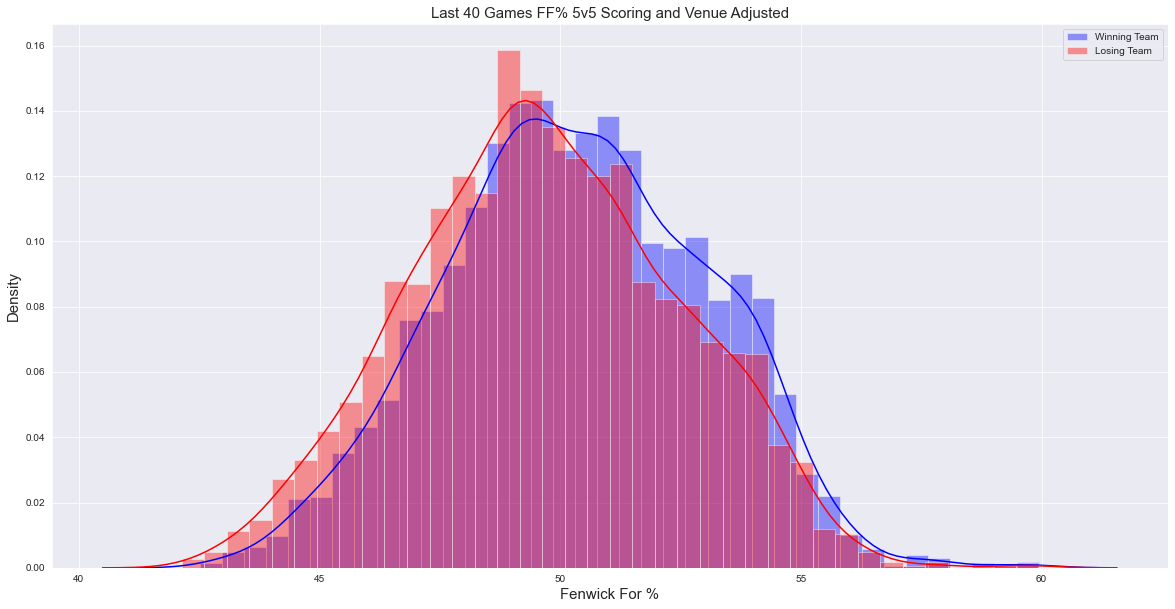

In [211]:
fig,ax = plt.subplots(figsize = (20,10))

ax = sns.distplot(df_winner['winner_last_40_FF%_5v5'], color = 'blue', label = 'Winning Team')
ax = sns.distplot(df_winner['loser_last_40_FF%_5v5'], color = 'red', label = 'Losing Team')
# ax = sns.distplot(df[df['Bankrupt?']==1]['ROA(A) before interest and % after tax'].apply(lambda x: x*100), color = 'red', label = 'Bankrupt')
ax.set_title('Last 40 Games FF% 5v5 Scoring and Venue Adjusted', fontsize = 15)
ax.set_xlabel('Fenwick For %', fontsize = 15)
ax.set_ylabel('Density', fontsize = 15)
ax.legend(loc = 'upper right')
# ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.show()

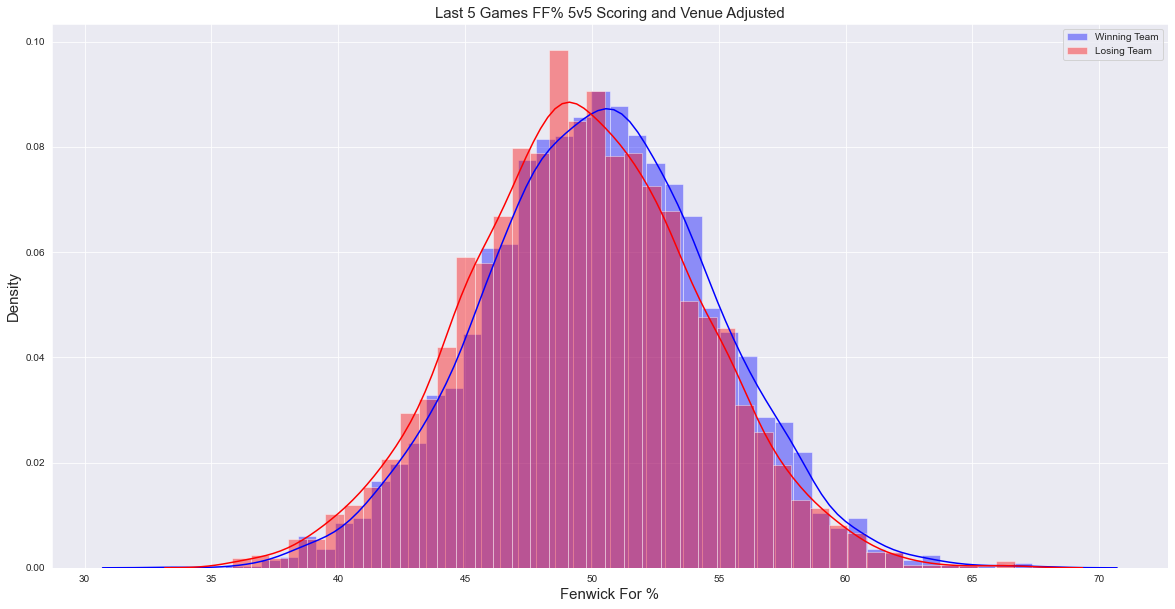

In [213]:
fig,ax = plt.subplots(figsize = (20,10))

ax = sns.distplot(df_winner['winner_last_5_FF%_5v5'], color = 'blue', label = 'Winning Team')
ax = sns.distplot(df_winner['loser_last_5_FF%_5v5'], color = 'red', label = 'Losing Team')
# ax = sns.distplot(df[df['Bankrupt?']==1]['ROA(A) before interest and % after tax'].apply(lambda x: x*100), color = 'red', label = 'Bankrupt')
ax.set_title('Last 5 Games FF% 5v5 Scoring and Venue Adjusted', fontsize = 15)
ax.set_xlabel('Fenwick For %', fontsize = 15)
ax.set_ylabel('Density', fontsize = 15)
ax.legend(loc = 'upper right')
# ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.show()

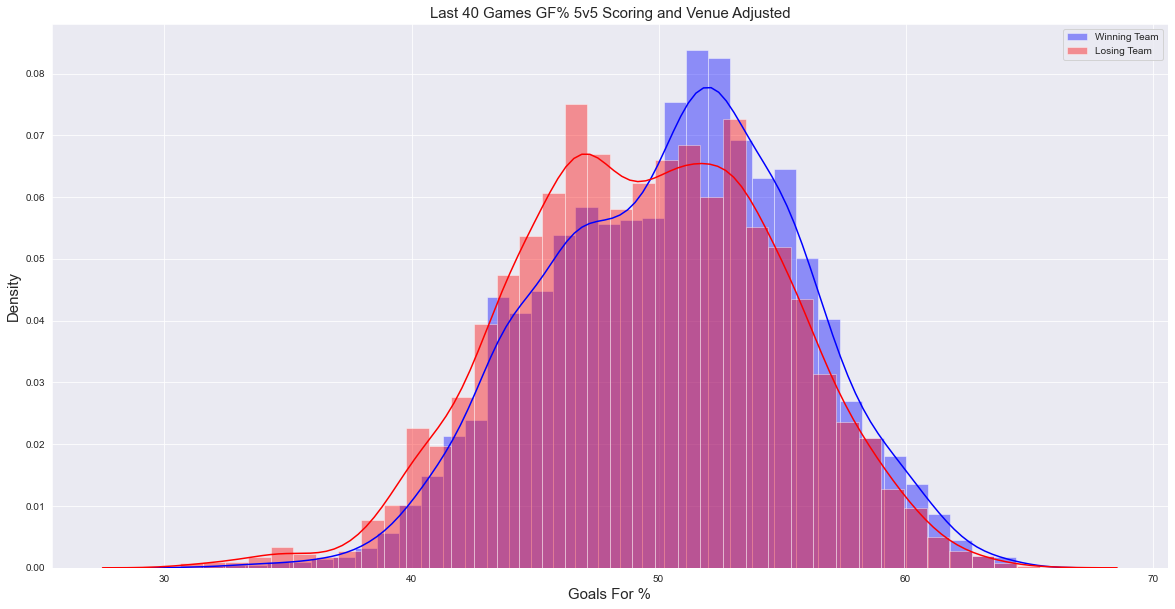

In [215]:
fig,ax = plt.subplots(figsize = (20,10))

ax = sns.distplot(df_winner['winner_last_40_GF%_5v5'], color = 'blue', label = 'Winning Team')
ax = sns.distplot(df_winner['loser_last_40_GF%_5v5'], color = 'red', label = 'Losing Team')
# ax = sns.distplot(df[df['Bankrupt?']==1]['ROA(A) before interest and % after tax'].apply(lambda x: x*100), color = 'red', label = 'Bankrupt')
ax.set_title('Last 40 Games GF% 5v5 Scoring and Venue Adjusted', fontsize = 15)
ax.set_xlabel('Goals For %', fontsize = 15)
ax.set_ylabel('Density', fontsize = 15)
ax.legend(loc = 'upper right')
# ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.show()

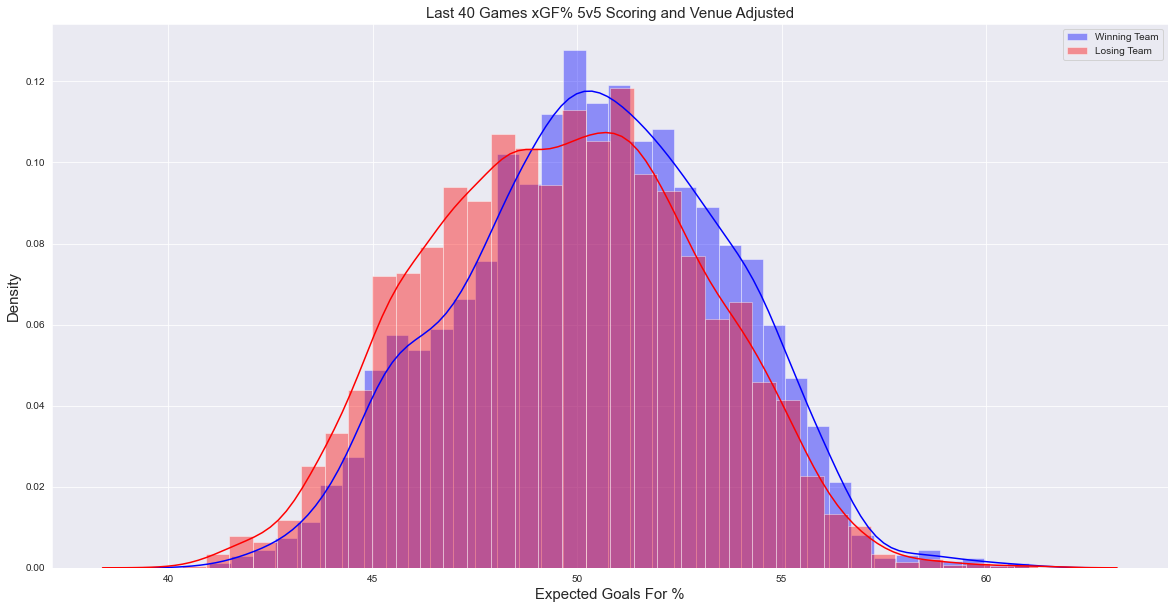

In [219]:
fig,ax = plt.subplots(figsize = (20,10))

ax = sns.distplot(df_winner['winner_last_40_xGF%_5v5'], color = 'blue', label = 'Winning Team')
ax = sns.distplot(df_winner['loser_last_40_xGF%_5v5'], color = 'red', label = 'Losing Team')

ax.set_title('Last 40 Games xGF% 5v5 Scoring and Venue Adjusted', fontsize = 15)
ax.set_xlabel('Expected Goals For %', fontsize = 15)
ax.set_ylabel('Density', fontsize = 15)
ax.legend(loc = 'upper right')
# ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.show()

In [220]:
df_winner

,game_id,date,venue,winner_team,loser_team,winner_score,loser_score,winner_Team_Won,winner_Goalie_FenwickSV%,winner_Goalie_GSAx/60,winner_Goalie_HDCSV%,loser_Goalie_FenwickSV%,loser_Goalie_GSAx/60,loser_Goalie_HDCSV%,winner_Game_Number,winner_B2B,winner_last_5_FF%_5v5,winner_last_5_GF%_5v5,winner_last_5_xGF%_5v5,winner_last_5_SH%,winner_last5_pp_TOI_per_game,winner_last5_xGF_per_min_pp,winner_last5_pk_TOI_per_game,winner_last5_xGA_per_min_pk,winner_last_40_FF%_5v5,winner_last_40_GF%_5v5,winner_last_40_xGF%_5v5,winner_last_40_SH%,winner_last40_pp_TOI_per_game,winner_last40_xGF_per_min_pp,winner_last40_pk_TOI_per_game,winner_last40_xGA_per_min_pk,loser_Game_Number,loser_B2B,loser_last_5_FF%_5v5,loser_last_5_GF%_5v5,loser_last_5_xGF%_5v5,loser_last_5_SH%,loser_last5_pp_TOI_per_game,loser_last5_xGF_per_min_pp,loser_last5_pk_TOI_per_game,loser_last5_xGA_per_min_pk,loser_last_40_FF%_5v5,loser_last_40_GF%_5v5,loser_last_40_xGF%_5v5,loser_last_40_SH%,loser_last40_pp_TOI_per_game,loser_last40_xGF_per_min_pp,loser_last40_pk_TOI_per_game,loser_last40_xGA_per_min_pk,Season,loser_Team_Won
2,2017020003,2017-10-04,Rogers Place,EDM,CGY,3,0,1.0,0.942539,0.312441,0.896450,0.940136,0.041876,0.891688,1.0,0.0,60.511924,58.385392,60.180542,8.478124,6.283333,0.113316,4.540000,0.131278,50.407241,56.575634,49.851785,9.025460,4.682500,0.132248,4.233750,0.116445,1.0,0.0,43.520998,45.427286,40.305523,9.286882,4.816667,0.153218,5.853333,0.112415,50.595552,50.499508,49.136336,7.879167,4.921667,0.120843,5.185417,0.107127,2017-2018,NaN
3,2017020003,2017-10-04,Rogers Place,EDM,CGY,3,0,1.0,0.942539,0.312441,0.896450,0.940136,0.041876,0.891688,1.0,0.0,60.511924,58.385392,60.180542,8.478124,6.283333,0.113316,4.540000,0.131278,50.407241,56.575634,49.851785,9.025460,4.682500,0.132248,4.233750,0.116445,1.0,0.0,43.520998,45.427286,40.305523,9.286882,4.816667,0.153218,5.853333,0.112415,50.595552,50.499508,49.136336,7.879167,4.921667,0.120843,5.185417,0.107127,2017-2018,NaN
5,2017020005,2017-10-05,TD Garden,BOS,NSH,4,3,1.0,0.930693,-0.464021,0.833333,0.941076,-0.260615,0.838174,1.0,0.0,52.400715,48.959081,50.929752,5.518246,2.690000,0.098885,5.446667,0.067197,55.762037,48.882718,54.871795,7.303942,4.482083,0.129293,5.193333,0.084868,1.0,0.0,47.102597,52.130045,43.637300,7.311321,6.066667,0.142088,3.630000,0.107438,51.309591,52.122642,50.381002,7.885816,4.720833,0.087855,4.475833,0.102718,2017-2018,NaN
9,2017020009,2017-10-05,Little Caesars Arena,DET,MIN,4,2,1.0,0.948798,0.284811,0.896154,0.932856,-0.716074,0.841880,1.0,0.0,49.469527,43.239152,49.469777,6.430072,2.510000,0.112351,3.403333,0.061704,47.614221,45.950027,47.403962,7.820550,4.629167,0.105797,4.516667,0.119336,1.0,0.0,57.868703,58.964646,63.606735,8.788107,2.510000,0.183267,4.340000,0.124885,51.867753,51.540585,56.750434,8.686489,4.518333,0.117411,3.872500,0.107618,2017-2018,NaN
10,2017020010,2017-10-05,United Center,CHI,PIT,10,1,1.0,0.935012,-0.173141,0.868263,0.940486,0.194748,0.874644,1.0,0.0,50.806103,46.941896,50.291159,4.933708,5.416667,0.060185,4.766667,0.135944,52.514084,54.663774,51.617421,8.719886,4.422917,0.103156,4.016250,0.122004,2.0,1.0,43.579393,59.569075,47.208791,13.494114,4.120000,0.145631,3.683333,0.145520,50.626887,57.691589,51.992249,8.968961,4.822500,0.126439,4.735833,0.129386,2017-2018,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4578,2020020778,2021-04-28,Xcel Energy Center,STL,MIN,4,3,NaN,0.935484,0.015248,0.860058,0.949810,0.227475,0.870079,44.0,0.0,43.571811,51.447135,38.229871,8.784670,5.083333,0.108197,5.523333,0.139409,47.495862,46.196132,46.232558,7.598031,4.621250,0.115066,4.749167,0.140604,42.0,0.0,44.714334,64.552239,45.864198,14.720620,4.093333,0.113355,3.023333,0.173980,46.414302,57.008324,49.803660,11.097313,5.147083,0.101708,5.353333,0.089851,2020-2021,0.0
4579,2020020778,2021-04-28,Xcel Energy Center,S

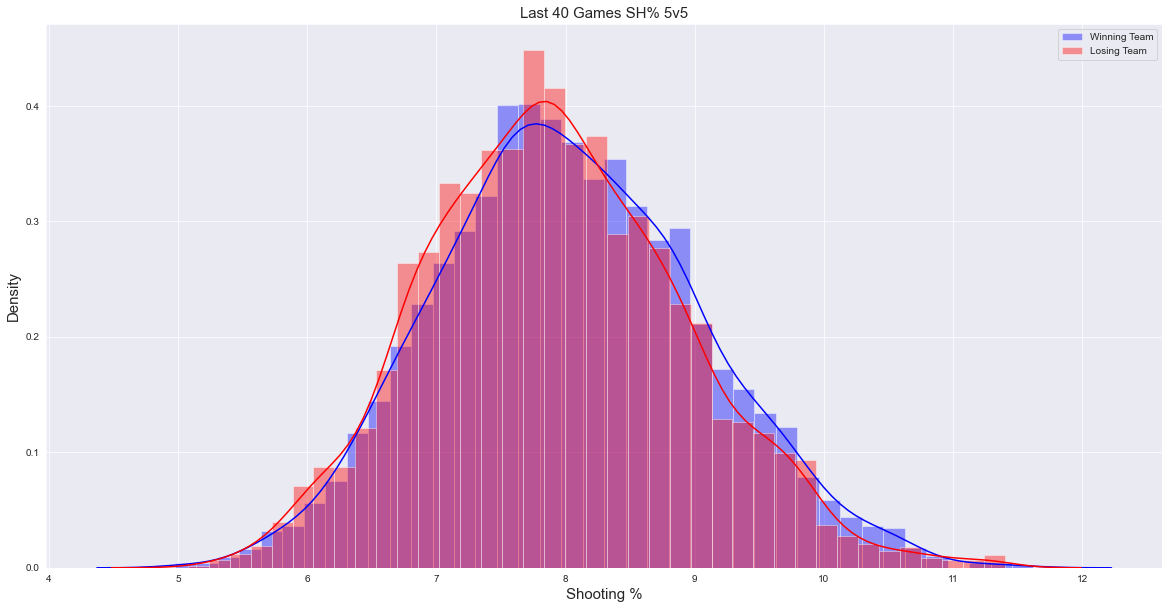

In [224]:
fig,ax = plt.subplots(figsize = (20,10))

ax = sns.distplot(df_winner['winner_last_40_SH%'], color = 'blue', label = 'Winning Team')
ax = sns.distplot(df_winner['loser_last_40_SH%'], color = 'red', label = 'Losing Team')

ax.set_title('Last 40 Games SH% 5v5', fontsize = 15)
ax.set_xlabel('Shooting %', fontsize = 15)
ax.set_ylabel('Density', fontsize = 15)
ax.legend(loc = 'upper right')
# ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.show()

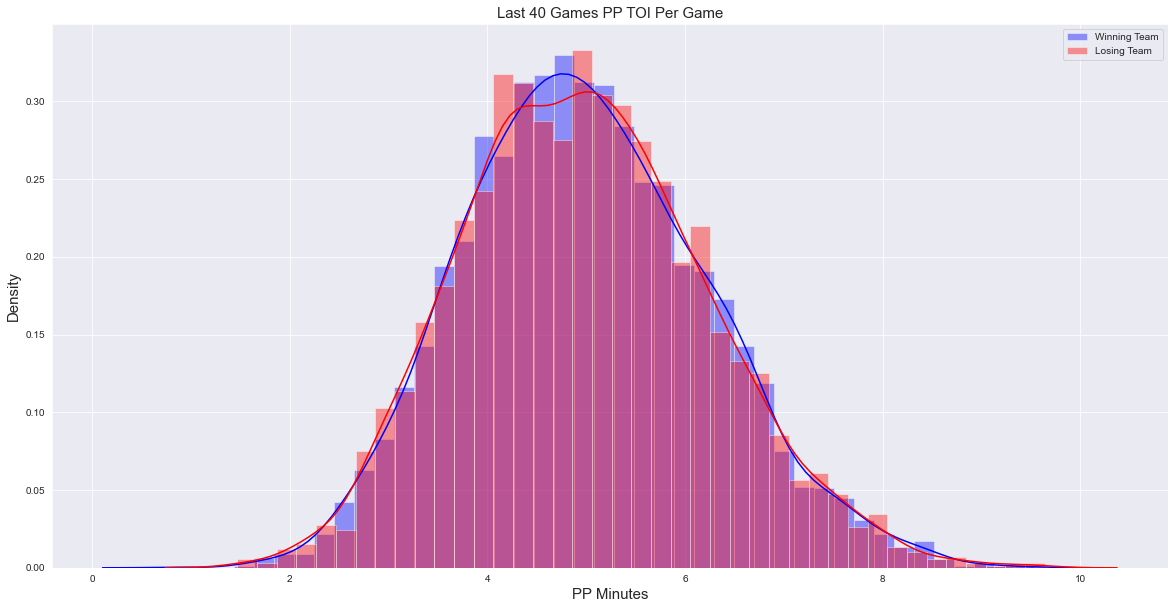

In [230]:
fig,ax = plt.subplots(figsize = (20,10))

ax = sns.distplot(df_winner['winner_last5_pp_TOI_per_game'], color = 'blue', label = 'Winning Team')
ax = sns.distplot(df_winner['loser_last5_pp_TOI_per_game'], color = 'red', label = 'Losing Team')

ax.set_title('Last 40 Games PP TOI Per Game', fontsize = 15)
ax.set_xlabel('PP Minutes', fontsize = 15)
ax.set_ylabel('Density', fontsize = 15)
ax.legend(loc = 'upper right')
# ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.show()

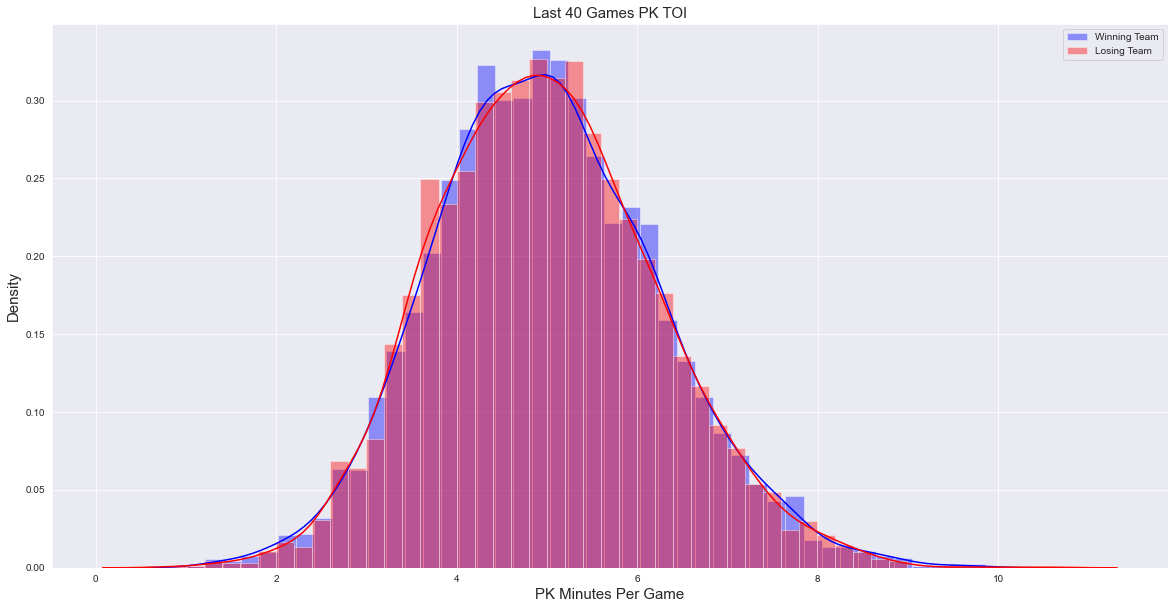

In [229]:
fig,ax = plt.subplots(figsize = (20,10))

ax = sns.distplot(df_winner['winner_last5_pk_TOI_per_game'], color = 'blue', label = 'Winning Team')
ax = sns.distplot(df_winner['loser_last5_pk_TOI_per_game'], color = 'red', label = 'Losing Team')

ax.set_title('Last 40 Games PK TOI', fontsize = 15)
ax.set_xlabel('PK Minutes Per Game', fontsize = 15)
ax.set_ylabel('Density', fontsize = 15)
ax.legend(loc = 'upper right')
# ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.show()

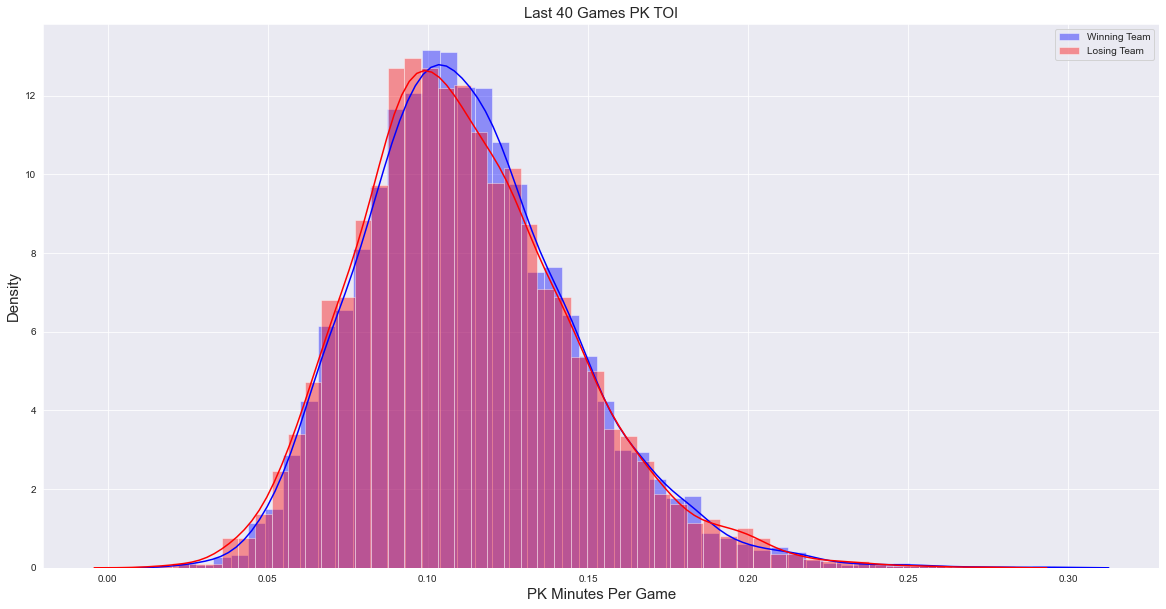

In [234]:
fig,ax = plt.subplots(figsize = (20,10))

ax = sns.distplot(df_winner['winner_last5_xGF_per_min_pp'], color = 'blue', label = 'Winning Team')
ax = sns.distplot(df_winner['loser_last5_xGF_per_min_pp'], color = 'red', label = 'Losing Team')

ax.set_title('Last 40 Games PK TOI', fontsize = 15)
ax.set_xlabel('PK Minutes Per Game', fontsize = 15)
ax.set_ylabel('Density', fontsize = 15)
ax.legend(loc = 'upper right')
# ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.show()

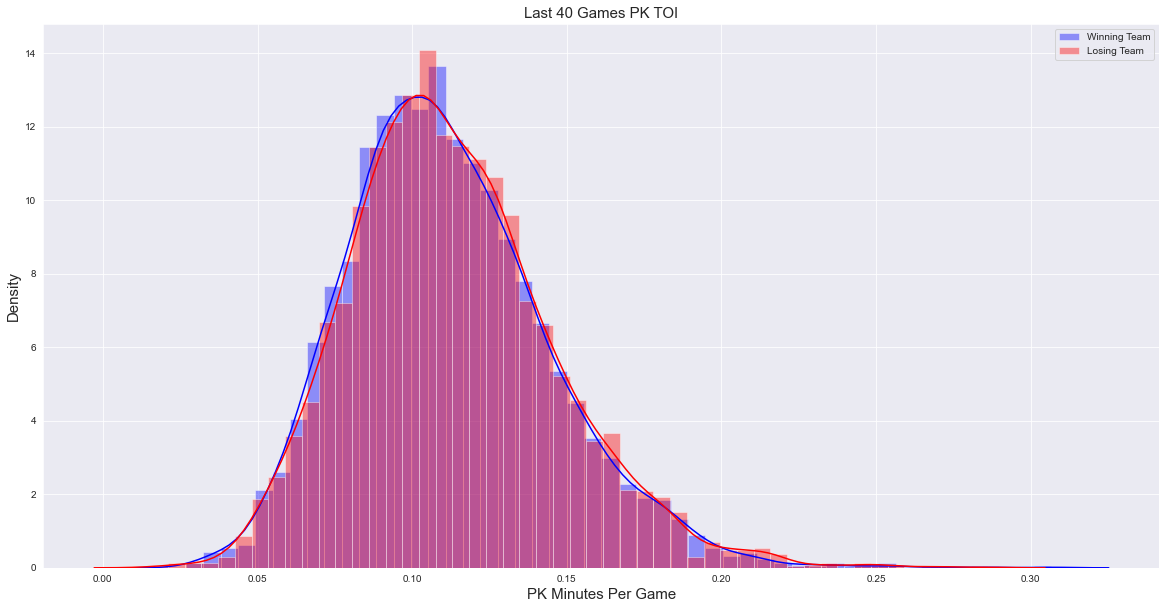

In [233]:
fig,ax = plt.subplots(figsize = (20,10))

ax = sns.distplot(df_winner['winner_last5_xGA_per_min_pk'], color = 'blue', label = 'Winning Team')
ax = sns.distplot(df_winner['loser_last5_xGA_per_min_pk'], color = 'red', label = 'Losing Team')

ax.set_title('Last 40 Games PK TOI', fontsize = 15)
ax.set_xlabel('PK Minutes Per Game', fontsize = 15)
ax.set_ylabel('Density', fontsize = 15)
ax.legend(loc = 'upper right')
# ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.show()

In [235]:
df_winner.head()

,game_id,date,venue,winner_team,loser_team,winner_score,loser_score,winner_Team_Won,winner_Goalie_FenwickSV%,winner_Goalie_GSAx/60,winner_Goalie_HDCSV%,loser_Goalie_FenwickSV%,loser_Goalie_GSAx/60,loser_Goalie_HDCSV%,winner_Game_Number,winner_B2B,winner_last_5_FF%_5v5,winner_last_5_GF%_5v5,winner_last_5_xGF%_5v5,winner_last_5_SH%,winner_last5_pp_TOI_per_game,winner_last5_xGF_per_min_pp,winner_last5_pk_TOI_per_game,winner_last5_xGA_per_min_pk,winner_last_40_FF%_5v5,winner_last_40_GF%_5v5,winner_last_40_xGF%_5v5,winner_last_40_SH%,winner_last40_pp_TOI_per_game,winner_last40_xGF_per_min_pp,winner_last40_pk_TOI_per_game,winner_last40_xGA_per_min_pk,loser_Game_Number,loser_B2B,loser_last_5_FF%_5v5,loser_last_5_GF%_5v5,loser_last_5_xGF%_5v5,loser_last_5_SH%,loser_last5_pp_TOI_per_game,loser_last5_xGF_per_min_pp,loser_last5_pk_TOI_per_game,loser_last5_xGA_per_min_pk,loser_last_40_FF%_5v5,loser_last_40_GF%_5v5,loser_last_40_xGF%_5v5,loser_last_40_SH%,loser_last40_pp_TOI_per_game,loser_last40_xGF_per_min_pp,loser_last40_pk_TOI_per_game,loser_last40_xGA_per_min_pk,Season,loser_Team_Won
2,2017020003,2017-10-04,Rogers Place,EDM,CGY,3,0,1.0,0.942539,0.312441,0.896450,0.940136,0.041876,0.891688,1.0,0.0,60.511924,58.385392,60.180542,8.478124,6.283333,0.113316,4.540000,0.131278,50.407241,56.575634,49.851785,9.025460,4.682500,0.132248,4.233750,0.116445,1.0,0.0,43.520998,45.427286,40.305523,9.286882,4.816667,0.153218,5.853333,0.112415,50.595552,50.499508,49.136336,7.879167,4.921667,0.120843,5.185417,0.107127,2017-2018,NaN
3,2017020003,2017-10-04,Rogers Place,EDM,CGY,3,0,1.0,0.942539,0.312441,0.896450,0.940136,0.041876,0.891688,1.0,0.0,60.511924,58.385392,60.180542,8.478124,6.283333,0.113316,4.540000,0.131278,50.407241,56.575634,49.851785,9.025460,4.682500,0.132248,4.233750,0.116445,1.0,0.0,43.520998,45.427286,40.305523,9.286882,4.816667,0.153218,5.853333,0.112415,50.595552,50.499508,49.136336,7.879167,4.921667,0.120843,5.185417,0.107127,2017-2018,NaN
5,2017020005,2017-10-05,TD Garden,BOS,NSH,4,3,1.0,0.930693,-0.464021,0.833333,0.941076,-0.260615,0.838174,1.0,0.0,52.400715,48.959081,50.929752,5.518246,2.690000,0.098885,5.446667,0.067197,55.762037,48.882718,54.871795,7.303942,4.482083,0.129293,5.193333,0.084868,1.0,0.0,47.102597,52.130045,43.637300,7.311321,6.066667,0.142088,3.630000,0.107438,51.309591,52.122642,50.381002,7.885816,4.720833,0.087855,4.475833,0.102718,2017-2018,NaN
9,2017020009,2017-10-05,Little Caesars Arena,DET,MIN,4,2,1.0,0.948798,0.284811,0.896154,0.932856,-0.716074,0.841880,1.0,0.0,49.469527,43.239152,49.469777,6.430072,2.510000,0.112351,3.403333,0.061704,47.614221,45.950027,47.403962,7.820550,4.629167,0.105797,4.516667,0.119336,1.0,0.0,57.868703,58.964646,63.606735,8.788107,2.510000,0.183267,4.340000,0.124885,51.867753,51.540585,56.750434,8.686489,4.518333,0.117411,3.872500,0.107618,2017-2018,NaN
10,2017020010,2017-10-05,United Center,CHI,PIT,10,1,1.0,0.935012,-0.173141,0.868263,0.940486,0.194748,0.874644,1.0,0.0,50.806103,46.941896,50.291159,4.933708,5.416667,0.060185,4.766667,0.135944,52.514084,54.663774,51.617421,8.719886,4.422917,0.103156,4.016250,0.122004,2.0,1.0,43.579393,59.569075,47.208791,13.494114,4.120000,0.145631,3.683333,0.145520,50.626887,57.691589,51.992249,8.968961,4.822500,0.126439,4.735833,0.129386,2017-2018,NaN


In [241]:
infile = open("data/inexperienced_goalie_imputes.pickle",'rb')
ig = pickle.load(infile)
infile.close()

In [252]:
ig

[0.9346311576658926,
 -131.32000000000016,
 -0.2815221605089356,
 0.8591820987654321]

In [243]:
ig_FenwickSV, ig_GSAx , ig_GSAx60 , ig_HDCSV = ig[0], ig[1], ig[2], ig[3]

In [245]:
df_winner[df_winner['winner_Goalie_FenwickSV%'] != ig_FenwickSV]

,game_id,date,venue,winner_team,loser_team,winner_score,loser_score,winner_Team_Won,winner_Goalie_FenwickSV%,winner_Goalie_GSAx/60,winner_Goalie_HDCSV%,loser_Goalie_FenwickSV%,loser_Goalie_GSAx/60,loser_Goalie_HDCSV%,winner_Game_Number,winner_B2B,winner_last_5_FF%_5v5,winner_last_5_GF%_5v5,winner_last_5_xGF%_5v5,winner_last_5_SH%,winner_last5_pp_TOI_per_game,winner_last5_xGF_per_min_pp,winner_last5_pk_TOI_per_game,winner_last5_xGA_per_min_pk,winner_last_40_FF%_5v5,winner_last_40_GF%_5v5,winner_last_40_xGF%_5v5,winner_last_40_SH%,winner_last40_pp_TOI_per_game,winner_last40_xGF_per_min_pp,winner_last40_pk_TOI_per_game,winner_last40_xGA_per_min_pk,loser_Game_Number,loser_B2B,loser_last_5_FF%_5v5,loser_last_5_GF%_5v5,loser_last_5_xGF%_5v5,loser_last_5_SH%,loser_last5_pp_TOI_per_game,loser_last5_xGF_per_min_pp,loser_last5_pk_TOI_per_game,loser_last5_xGA_per_min_pk,loser_last_40_FF%_5v5,loser_last_40_GF%_5v5,loser_last_40_xGF%_5v5,loser_last_40_SH%,loser_last40_pp_TOI_per_game,loser_last40_xGF_per_min_pp,loser_last40_pk_TOI_per_game,loser_last40_xGA_per_min_pk,Season,loser_Team_Won
2,2017020003,2017-10-04,Rogers Place,EDM,CGY,3,0,1.0,0.942539,0.312441,0.896450,0.940136,0.041876,0.891688,1.0,0.0,60.511924,58.385392,60.180542,8.478124,6.283333,0.113316,4.540000,0.131278,50.407241,56.575634,49.851785,9.025460,4.682500,0.132248,4.233750,0.116445,1.0,0.0,43.520998,45.427286,40.305523,9.286882,4.816667,0.153218,5.853333,0.112415,50.595552,50.499508,49.136336,7.879167,4.921667,0.120843,5.185417,0.107127,2017-2018,NaN
3,2017020003,2017-10-04,Rogers Place,EDM,CGY,3,0,1.0,0.942539,0.312441,0.896450,0.940136,0.041876,0.891688,1.0,0.0,60.511924,58.385392,60.180542,8.478124,6.283333,0.113316,4.540000,0.131278,50.407241,56.575634,49.851785,9.025460,4.682500,0.132248,4.233750,0.116445,1.0,0.0,43.520998,45.427286,40.305523,9.286882,4.816667,0.153218,5.853333,0.112415,50.595552,50.499508,49.136336,7.879167,4.921667,0.120843,5.185417,0.107127,2017-2018,NaN
5,2017020005,2017-10-05,TD Garden,BOS,NSH,4,3,1.0,0.930693,-0.464021,0.833333,0.941076,-0.260615,0.838174,1.0,0.0,52.400715,48.959081,50.929752,5.518246,2.690000,0.098885,5.446667,0.067197,55.762037,48.882718,54.871795,7.303942,4.482083,0.129293,5.193333,0.084868,1.0,0.0,47.102597,52.130045,43.637300,7.311321,6.066667,0.142088,3.630000,0.107438,51.309591,52.122642,50.381002,7.885816,4.720833,0.087855,4.475833,0.102718,2017-2018,NaN
9,2017020009,2017-10-05,Little Caesars Arena,DET,MIN,4,2,1.0,0.948798,0.284811,0.896154,0.932856,-0.716074,0.841880,1.0,0.0,49.469527,43.239152,49.469777,6.430072,2.510000,0.112351,3.403333,0.061704,47.614221,45.950027,47.403962,7.820550,4.629167,0.105797,4.516667,0.119336,1.0,0.0,57.868703,58.964646,63.606735,8.788107,2.510000,0.183267,4.340000,0.124885,51.867753,51.540585,56.750434,8.686489,4.518333,0.117411,3.872500,0.107618,2017-2018,NaN
10,2017020010,2017-10-05,United Center,CHI,PIT,10,1,1.0,0.935012,-0.173141,0.868263,0.940486,0.194748,0.874644,1.0,0.0,50.806103,46.941896,50.291159,4.933708,5.416667,0.060185,4.766667,0.135944,52.514084,54.663774,51.617421,8.719886,4.422917,0.103156,4.016250,0.122004,2.0,1.0,43.579393,59.569075,47.208791,13.494114,4.120000,0.145631,3.683333,0.145520,50.626887,57.691589,51.992249,8.968961,4.822500,0.126439,4.735833,0.129386,2017-2018,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4578,2020020778,2021-04-28,Xcel Energy Center,STL,MIN,4,3,NaN,0.935484,0.015248,0.860058,0.949810,0.227475,0.870079,44.0,0.0,43.571811,51.447135,38.229871,8.784670,5.083333,0.108197,5.523333,0.139409,47.495862,46.196132,46.232558,7.598031,4.621250,0.115066,4.749167,0.140604,42.0,0.0,44.714334,64.552239,45.864198,14.720620,4.093333,0.113355,3.023333,0.173980,46.414302,57.008324,49.803660,11.097313,5.147083,0.101708,5.353333,0.089851,2020-2021,0.0
4579,2020020778,2021-04-28,Xcel Energy Center,S

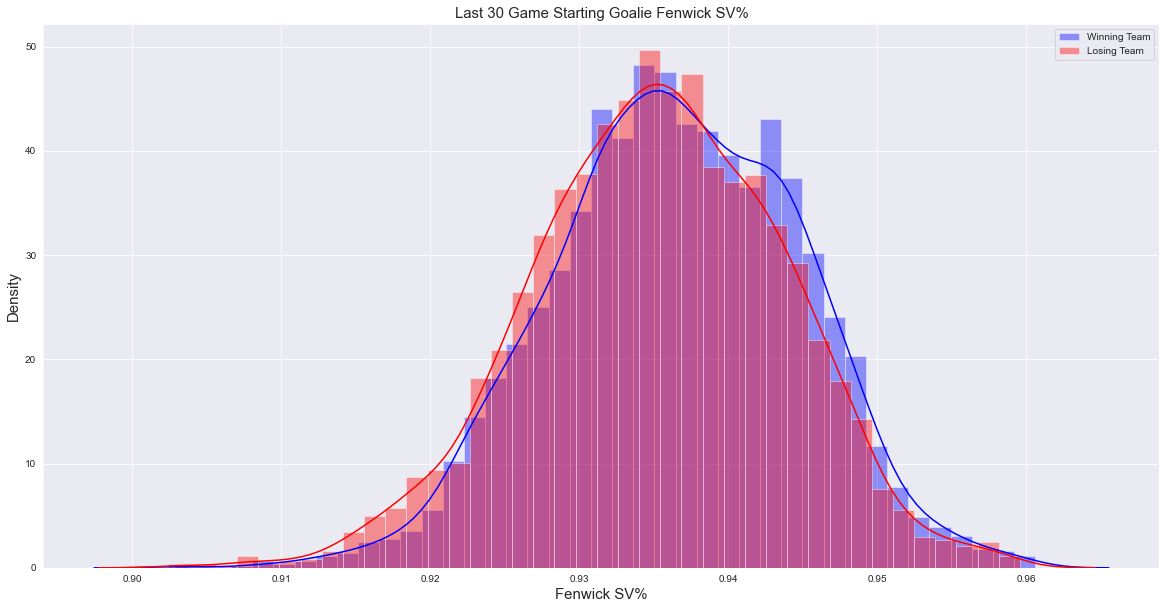

In [263]:
fig,ax = plt.subplots(figsize = (20,10))

ax = sns.distplot(df_winner[df_winner['winner_Goalie_FenwickSV%'] != ig_FenwickSV]['winner_Goalie_FenwickSV%'] , color = 'blue', label = 'Winning Team')
ax = sns.distplot(df_winner[df_winner['loser_Goalie_FenwickSV%'] != ig_FenwickSV]['loser_Goalie_FenwickSV%'], color = 'red', label = 'Losing Team')

ax.set_title('Last 30 Game Starting Goalie Fenwick SV%', fontsize = 15)
ax.set_xlabel('Fenwick SV%', fontsize = 15)
ax.set_ylabel('Density', fontsize = 15)
ax.legend(loc = 'upper right')
# ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.show()

In [266]:
ig_GSAx60 = df_winner['winner_Goalie_GSAx/60'].mode()[0]

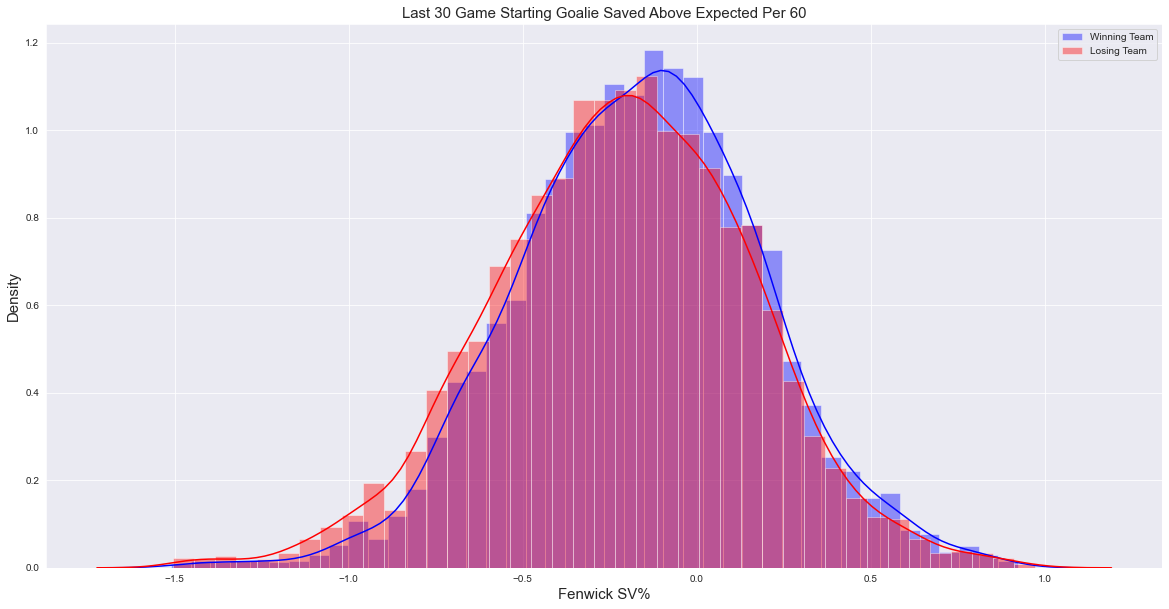

In [271]:
fig,ax = plt.subplots(figsize = (20,10))

ax = sns.distplot(df_winner[df_winner['winner_Goalie_GSAx/60'] != ig_GSAx60]['winner_Goalie_GSAx/60'], color = 'blue', label = 'Winning Team')
ax = sns.distplot(df_winner[df_winner['loser_Goalie_GSAx/60'] != ig_GSAx60]['loser_Goalie_GSAx/60'], color = 'red', label = 'Losing Team')

ax.set_title('Last 30 Game Starting Goalie Saved Above Expected Per 60', fontsize = 15)
ax.set_xlabel('Fenwick SV%', fontsize = 15)
ax.set_ylabel('Density', fontsize = 15)
ax.legend(loc = 'upper right')
# ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.show()

In [274]:
df_winner[df_winner['winner_Goalie_HDCSV%'] != ig_HDCSV]

,game_id,date,venue,winner_team,loser_team,winner_score,loser_score,winner_Team_Won,winner_Goalie_FenwickSV%,winner_Goalie_GSAx/60,winner_Goalie_HDCSV%,loser_Goalie_FenwickSV%,loser_Goalie_GSAx/60,loser_Goalie_HDCSV%,winner_Game_Number,winner_B2B,winner_last_5_FF%_5v5,winner_last_5_GF%_5v5,winner_last_5_xGF%_5v5,winner_last_5_SH%,winner_last5_pp_TOI_per_game,winner_last5_xGF_per_min_pp,winner_last5_pk_TOI_per_game,winner_last5_xGA_per_min_pk,winner_last_40_FF%_5v5,winner_last_40_GF%_5v5,winner_last_40_xGF%_5v5,winner_last_40_SH%,winner_last40_pp_TOI_per_game,winner_last40_xGF_per_min_pp,winner_last40_pk_TOI_per_game,winner_last40_xGA_per_min_pk,loser_Game_Number,loser_B2B,loser_last_5_FF%_5v5,loser_last_5_GF%_5v5,loser_last_5_xGF%_5v5,loser_last_5_SH%,loser_last5_pp_TOI_per_game,loser_last5_xGF_per_min_pp,loser_last5_pk_TOI_per_game,loser_last5_xGA_per_min_pk,loser_last_40_FF%_5v5,loser_last_40_GF%_5v5,loser_last_40_xGF%_5v5,loser_last_40_SH%,loser_last40_pp_TOI_per_game,loser_last40_xGF_per_min_pp,loser_last40_pk_TOI_per_game,loser_last40_xGA_per_min_pk,Season,loser_Team_Won
2,2017020003,2017-10-04,Rogers Place,EDM,CGY,3,0,1.0,0.942539,0.312441,0.896450,0.940136,0.041876,0.891688,1.0,0.0,60.511924,58.385392,60.180542,8.478124,6.283333,0.113316,4.540000,0.131278,50.407241,56.575634,49.851785,9.025460,4.682500,0.132248,4.233750,0.116445,1.0,0.0,43.520998,45.427286,40.305523,9.286882,4.816667,0.153218,5.853333,0.112415,50.595552,50.499508,49.136336,7.879167,4.921667,0.120843,5.185417,0.107127,2017-2018,NaN
3,2017020003,2017-10-04,Rogers Place,EDM,CGY,3,0,1.0,0.942539,0.312441,0.896450,0.940136,0.041876,0.891688,1.0,0.0,60.511924,58.385392,60.180542,8.478124,6.283333,0.113316,4.540000,0.131278,50.407241,56.575634,49.851785,9.025460,4.682500,0.132248,4.233750,0.116445,1.0,0.0,43.520998,45.427286,40.305523,9.286882,4.816667,0.153218,5.853333,0.112415,50.595552,50.499508,49.136336,7.879167,4.921667,0.120843,5.185417,0.107127,2017-2018,NaN
5,2017020005,2017-10-05,TD Garden,BOS,NSH,4,3,1.0,0.930693,-0.464021,0.833333,0.941076,-0.260615,0.838174,1.0,0.0,52.400715,48.959081,50.929752,5.518246,2.690000,0.098885,5.446667,0.067197,55.762037,48.882718,54.871795,7.303942,4.482083,0.129293,5.193333,0.084868,1.0,0.0,47.102597,52.130045,43.637300,7.311321,6.066667,0.142088,3.630000,0.107438,51.309591,52.122642,50.381002,7.885816,4.720833,0.087855,4.475833,0.102718,2017-2018,NaN
9,2017020009,2017-10-05,Little Caesars Arena,DET,MIN,4,2,1.0,0.948798,0.284811,0.896154,0.932856,-0.716074,0.841880,1.0,0.0,49.469527,43.239152,49.469777,6.430072,2.510000,0.112351,3.403333,0.061704,47.614221,45.950027,47.403962,7.820550,4.629167,0.105797,4.516667,0.119336,1.0,0.0,57.868703,58.964646,63.606735,8.788107,2.510000,0.183267,4.340000,0.124885,51.867753,51.540585,56.750434,8.686489,4.518333,0.117411,3.872500,0.107618,2017-2018,NaN
10,2017020010,2017-10-05,United Center,CHI,PIT,10,1,1.0,0.935012,-0.173141,0.868263,0.940486,0.194748,0.874644,1.0,0.0,50.806103,46.941896,50.291159,4.933708,5.416667,0.060185,4.766667,0.135944,52.514084,54.663774,51.617421,8.719886,4.422917,0.103156,4.016250,0.122004,2.0,1.0,43.579393,59.569075,47.208791,13.494114,4.120000,0.145631,3.683333,0.145520,50.626887,57.691589,51.992249,8.968961,4.822500,0.126439,4.735833,0.129386,2017-2018,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4578,2020020778,2021-04-28,Xcel Energy Center,STL,MIN,4,3,NaN,0.935484,0.015248,0.860058,0.949810,0.227475,0.870079,44.0,0.0,43.571811,51.447135,38.229871,8.784670,5.083333,0.108197,5.523333,0.139409,47.495862,46.196132,46.232558,7.598031,4.621250,0.115066,4.749167,0.140604,42.0,0.0,44.714334,64.552239,45.864198,14.720620,4.093333,0.113355,3.023333,0.173980,46.414302,57.008324,49.803660,11.097313,5.147083,0.101708,5.353333,0.089851,2020-2021,0.0
4579,2020020778,2021-04-28,Xcel Energy Center,S

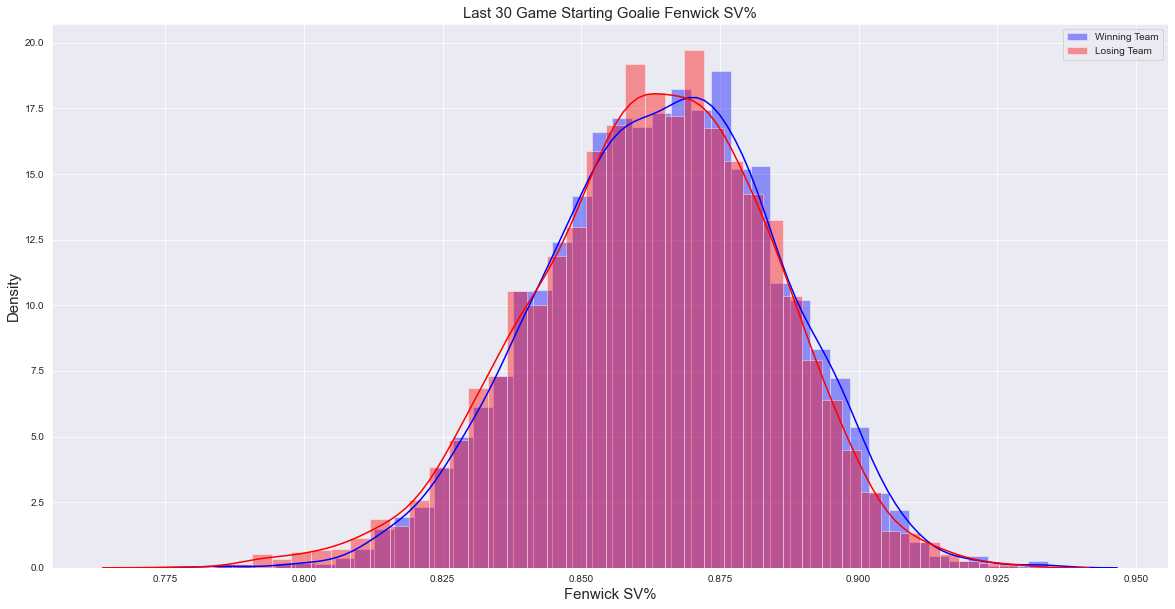

In [276]:
fig,ax = plt.subplots(figsize = (20,10))

ax = sns.distplot(df_winner[df_winner['winner_Goalie_HDCSV%'] != ig_HDCSV]['winner_Goalie_HDCSV%'], color = 'blue', label = 'Winning Team')
ax = sns.distplot(df_winner[df_winner['loser_Goalie_HDCSV%'] != ig_HDCSV]['loser_Goalie_HDCSV%'], color = 'red', label = 'Losing Team')

ax.set_title('Last 30 Game Starting Goalie Fenwick SV%', fontsize = 15)
ax.set_xlabel('Fenwick SV%', fontsize = 15)
ax.set_ylabel('Density', fontsize = 15)
ax.legend(loc = 'upper right')
# ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.show()

In [256]:
display(df_winner[(df_winner['winner_B2B'] ==1) & (df_winner['loser_B2B'] ==0)].shape[0])
display(df_winner[(df_winner['winner_B2B'] ==0) & (df_winner['loser_B2B'] ==1)].shape[0])

399

530

In [257]:
530/(399+530)

0.5705059203444564